# Bank Institution Term Deposit Predictive Model

The goal is to find a model that can predict which future clients who would subscribe to their term deposit. 

Having such an effective predictive model can help increase the campaign efficiency as they would be able to identify customers who would subscribe to their term deposit and thereby direct their marketing efforts to them. 

This would help them better manage their resources (e.g human effort, phone calls, time).

## Import the data

In [ ]:
import sys
import pydotplus

import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

from numpy import std
from numpy import mean
from sklearn import svm
from scipy import stats
from io import StringIO
from keras import regularizers
from xgboost import XGBClassifier
from IPython.display import Image  
from sklearn.manifold import TSNE
from keras.layers import Input, Dense
from sklearn.decomposition import PCA
from sklearn.tree import export_graphviz
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
from keras.models import Sequential, Model
from sklearn.externals.six import StringIO  
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from mlxtend.plotting import plot_decision_regions
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from keras.layers import Activation, Dense, Dropout, Input
from sklearn import preprocessing, metrics, model_selection

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [ ]:
#set seaborn style
sns.set(style="darkgrid")

colour_palette = "RdBu_r"
sns.set_palette(colour_palette)

In [ ]:
#Import the data into a dataframe called data through github link. 
#Set low memory to false because the dataset is large.
 
bank_additional_full = 'https://raw.githubusercontent.com/mwi-kali/Bank-Institution-Term-Deposit-Predictive-Model/master/data/bank-additional-full.csv'

data_bank_additional_full = pd.read_csv(bank_additional_full, sep=';', low_memory = False)

In [ ]:
data_bank_additional_full.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

## Data Exploration

This section attempts to understand the data. 

In [ ]:
print("In total: ", data_bank_additional_full.shape)
print("Missing data in total: ", data_bank_additional_full.isnull().sum().sum())
data_bank_additional_full.describe(include='all')

In total:  (41188, 21)
Missing data in total:  0


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,41188.00000,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188.000000,41188.000000,41188.000000,41188.000000,41188,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188
unique,NaN,12,4,8,3,3,3,2,10,5,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,2
top,NaN,admin.,married,university.degree,no,yes,no,cellular,may,thu,NaN,NaN,NaN,NaN,nonexistent,NaN,NaN,NaN,NaN,NaN,no
freq,NaN,10422,24928,12168,32588,21576,33950,26144,13769,8623,NaN,NaN,NaN,NaN,35563,NaN,NaN,NaN,NaN,NaN,36548
mean,40.02406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,258.285010,2.567593,962.475454,0.172963,NaN,0.081886,93.575664,-40.502600,3.621291,5167.035911,NaN
std,10.42125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,259.279249,2.770014,186.910907,0.494901,NaN,1.570960,0.578840,4.628198,1.734447,72.251528,NaN
min,17.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,0.000000,0.000000,NaN,-3.400000,92.201000,-50.800000,0.634000,4963.600000,NaN
25%,32.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102.000000,1.000000,999.000000,0.000000,NaN,-1.800000,93.075000,-42.700000,1.344000,5099.100000,NaN
50%,38.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.000000,2.000000,999.000000,0.000000,NaN,1.100000,93.749000,-41.800000,4.857000,5191.000000,NaN
75%,47.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,319.000000,3.000000,999.000000,0.000000,NaN,1.400000,93.994000,-36.400000,4.961000,5228.100000,NaN


# Classification Model for Predicting Term Deposit

## Preprocessing

### Encoding categorical variables 
Using label encoder to transform them into numerical columns. 

It encodes target labels with value between 0 and n_classes-1. This approach is very simple and it involves converting each value in a column to a number.

In [ ]:
# Replacing categorical values with numerical values
label_encoder = LabelEncoder()
all_columns = list(data_bank_additional_full.columns)
for x in all_columns:
  if type(data_bank_additional_full[x][0]) == str:
    try:
      data_bank_additional_full[x] = label_encoder.fit_transform(data_bank_additional_full[x])
    except:
      continue

### Handling outliers
Using by replacing it with central measures of tendancies.


In [ ]:
all_columns = list(data_bank_additional_full.iloc[:,:20].columns)
for x in all_columns:
  try:
    data_bank_additional_full[x] = np.where(data_bank_additional_full[x] > data_bank_additional_full[x].quantile(0.975), data_bank_additional_full[x].quantile(0.50), data_bank_additional_full[x])
    data_bank_additional_full[x] = np.where(data_bank_additional_full[x] < data_bank_additional_full[x].quantile(0.025), data_bank_additional_full[x].quantile(0.50), data_bank_additional_full[x])
  except TypeError:
    continue

### Scaler to rescale all numerical columns
Using StandardScaler().

It standardizes features by removing the mean and scaling to unit variance.

In [ ]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(data_bank_additional_full.iloc[:,:20])
data_bank_additional_fullish = pd.DataFrame(scaled_df,columns = all_columns)
data_bank_additional_fullish['y'] = data_bank_additional_full['y']
data_bank_additional_full = data_bank_additional_fullish

### Feature Engineering
Transforming and Aggregating columns to create better features.

In [ ]:
X = data_bank_additional_full[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan','contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays','previous', 'poutcome', 'emp.var.rate', 'cons.price.idx','cons.conf.idx', 'euribor3m', 'nr.employed']]
y = data_bank_additional_full['y']

### Dimensionality Reductions Techniques.

#### TSNE (t-distributed Stochastic Neighbor Embedding)

It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data.

In [ ]:
tsne = TSNE(n_components=3)
X_tsne = tsne.fit_transform(X)
X_tsne = pd.DataFrame(X_tsne)

#### Autoencoders
Autoencoder is an unsupervised artificial neural network. Its procedure starts compressing the original data into a shortcode ignoring noise. Then, the algorithm uncompresses that code to generate an image as close as possible to the original input.

In [ ]:
# Choose size of the encoded representations (reduce our initial features to this number)
encoding_dim = 15
# Define input layer
input_data = Input(shape=(X.shape[1],))
# Define encoding layer
encoded = Dense(encoding_dim, activation='elu')(input_data)
# Define decoding layer
decoded = Dense(X.shape[1], activation='sigmoid')(encoded)
# Create the autoencoder model
autoencoder = Model(input_data, decoded)
#Compile the autoencoder model
autoencoder.compile(optimizer='adam',loss='binary_crossentropy')
#Fit to set and save to hist_auto for plotting purposes
hist_auto = autoencoder.fit(X, X,epochs=500,batch_size=256,shuffle=True)

Epoch 1/500
161/161 [==============================] - 0s 1ms/step - loss: 0.3539
Epoch 2/500
161/161 [==============================] - 0s 1ms/step - loss: -0.9592
Epoch 3/500
161/161 [==============================] - 0s 1ms/step - loss: -3.4802
Epoch 4/500
161/161 [==============================] - 0s 2ms/step - loss: -7.8465
Epoch 5/500
161/161 [==============================] - 0s 1ms/step - loss: -14.2734
Epoch 6/500
161/161 [==============================] - 0s 1ms/step - loss: -22.7777
Epoch 7/500
161/161 [==============================] - 0s 1ms/step - loss: -33.2029
Epoch 8/500
161/161 [==============================] - 0s 1ms/step - loss: -45.3782
Epoch 9/500
161/161 [==============================] - 0s 1ms/step - loss: -59.1651
Epoch 10/500
161/161 [==============================] - 0s 1ms/step - loss: -74.4882
Epoch 11/500
161/161 [==============================] - 0s 1ms/step - loss: -91.2861
Epoch 12/500
161/161 [==============================] - 0s 1ms/step - loss: -10

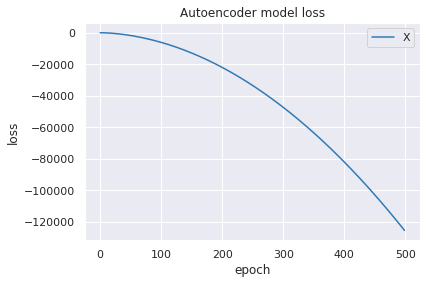

In [ ]:
# Summarize history for loss
plt.figure()
plt.plot(hist_auto.history['loss'])
plt.title('Autoencoder model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['X'], loc='upper right')
plt.show()

In [ ]:
# Create a separate model (encoder) in order to make encodings (first part of the autoencoder model)
encoder = Model(input_data, encoded)

# Create a placeholder for an encoded input
encoded_input = Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

# Encode and decode our test set (compare them visually just to get a first insight of the autoencoder's performance)
encoded_X = encoder.predict(X)
decoded_output = decoder.predict(encoded_X)

#Encode data set from above using the encoder
encoded_X = encoder.predict(X)

model = Sequential()
model.add(Dense(16, input_dim=encoded_X.shape[1],kernel_initializer='normal',activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation("sigmoid"))
model.compile(loss="binary_crossentropy", optimizer='adam')

history = model.fit(encoded_X, y, validation_split=0.2, epochs=100, batch_size=64)

Epoch 1/100
515/515 [==============================] - 1s 1ms/step - loss: 0.5841 - val_loss: 0.6775
Epoch 2/100
515/515 [==============================] - 1s 1ms/step - loss: 0.2432 - val_loss: 0.6339
Epoch 3/100
515/515 [==============================] - 1s 1ms/step - loss: 0.2245 - val_loss: 0.6675
Epoch 4/100
515/515 [==============================] - 1s 1ms/step - loss: 0.2181 - val_loss: 0.6496
Epoch 5/100
515/515 [==============================] - 1s 1ms/step - loss: 0.2142 - val_loss: 0.6247
Epoch 6/100
515/515 [==============================] - 1s 1ms/step - loss: 0.2129 - val_loss: 0.6521
Epoch 7/100
515/515 [==============================] - 1s 1ms/step - loss: 0.2101 - val_loss: 0.7850
Epoch 8/100
515/515 [==============================] - 1s 1ms/step - loss: 0.2096 - val_loss: 0.6316
Epoch 9/100
515/515 [==============================] - 1s 1ms/step - loss: 0.2082 - val_loss: 0.6969
Epoch 10/100
515/515 [==============================] - 1s 1ms/step - loss: 0.2085 - val_lo

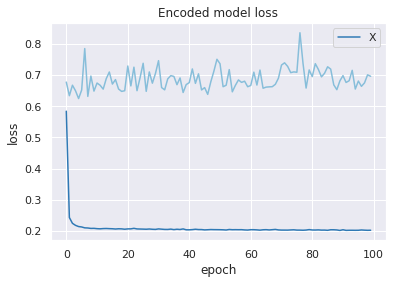

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Encoded model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['X'], loc='upper right')
plt.show()

In [ ]:
#Predict on set
predictions_prob = model.predict(encoded_X)
predictions_prob = predictions_prob[:,0]

predictions = np.where(predictions_prob > 0.5, 1, 0) 
#Turn probability to 0-1 binary output

#Print accuracy
acc = metrics.accuracy_score(y, predictions)
print('Overall accuracy of Neural Network model:', acc)

Overall accuracy of Neural Network model: 0.8878071282897931


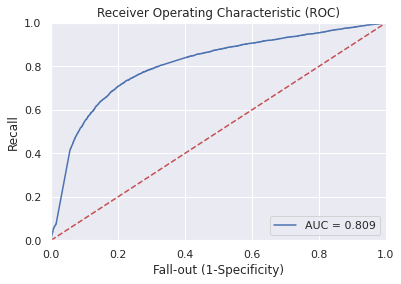

In [ ]:
#Print Area Under Curve
false_positive_rate, recall, thresholds = metrics.roc_curve(y, predictions_prob)
roc_auc = auc(false_positive_rate, recall)
plt.figure()
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

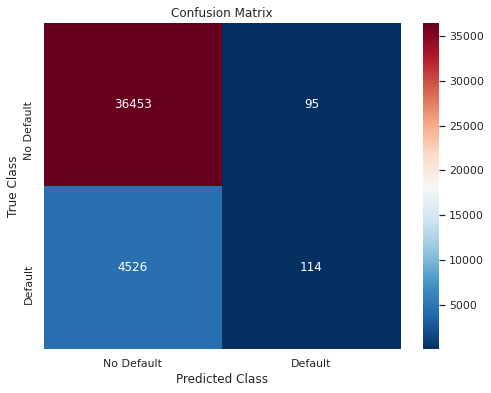

In [ ]:
#Print Confusion Matrix
cm = metrics.confusion_matrix(y, predictions)
labels = ['No Default', 'Default']
plt.figure(figsize=(8,6))
sns.heatmap(cm,xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap=colour_palette, vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [ ]:
decoded_output = pd.DataFrame(decoded_output)

In [ ]:
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
dense (Dense)                (None, 15)                315       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                320       
Total params: 635
Trainable params: 635
Non-trainable params: 0
_________________________________________________________________


#### PCA
Principal Component Analysis (PCA) is a linear dimensionality reduction technique that can be utilized for extracting information from a high-dimensional space by projecting it into a lower-dimensional sub-space. It tries to preserve the essential parts that have more variation of the data and remove the non-essential parts with fewer variation.

In [ ]:
pca = PCA()
X_pca = pca.fit_transform(X)
X_pca = pd.DataFrame(X_pca)

### Choosing Dimensionality Reductions Techniques

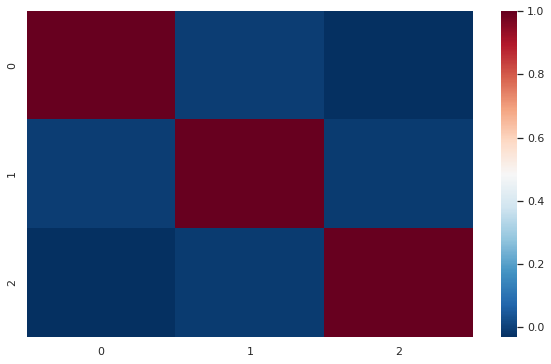

In [ ]:
figure = plt.figure(figsize=(10,6))
corrMatrix = X_tsne.corr()
sns.heatmap(corrMatrix, annot=False,cmap=colour_palette)
plt.show()

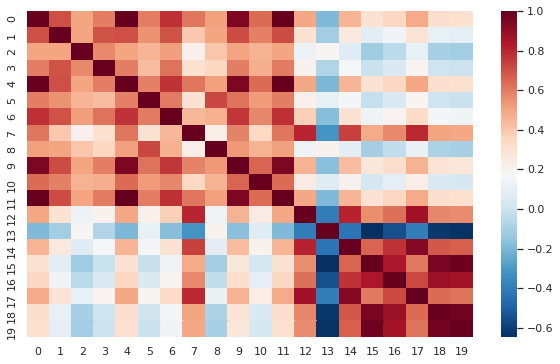

In [ ]:
figure = plt.figure(figsize=(10,6))
corrMatrix = decoded_output.corr()
sns.heatmap(corrMatrix, annot=False,cmap=colour_palette)
plt.show()

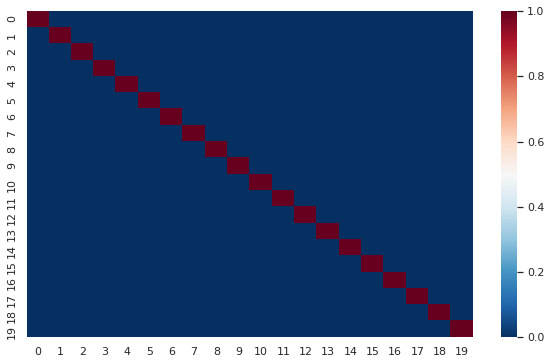

In [ ]:
figure = plt.figure(figsize=(10,6))
corrMatrix = X_pca.corr()
sns.heatmap(corrMatrix, annot=False,cmap=colour_palette)
plt.show()

PCA features are totally linearly uncorrelated with each other since features are projections onto the orthogonal basis. 

Autoencoded features might have correlations since they are just trained for accurate reconstruction.

The autoencoder output will be able to compress the information better into low dimensional latent space leveraging its capability to model complex non-linear functions.

## Train, Test Split

90% for training and 10% for testing

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(decoded_output, y, test_size=0.1, random_state=1)

## Selecting Machine Learning Models

Cross validation to select the best three machine learning models.Cross validation techniques used are Stratified K-fold and K-fold.

#### Helper function

In [ ]:
class helper:
  def __init__(self):
    print ("Helper object created")
  def confusion(self, y_pred):
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)

    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap=colour_palette ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

  def roc_plot(self,model):
    y_pred_proba = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    print("auc="+str(auc))
    plt.legend(loc=4)
    plt.show()

  def s_kfold(self,model):
    skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

    scores = cross_val_score(model, X_train, y_train, cv=skfold,scoring='accuracy')
    print('\nCross-Validation Accuracy Scores', scores)

    scores = pd.Series(scores)
    print('\nThe minimum Cross-Validation Accuracy is  %.4f ' % scores.min())
    print('\nThe mean Cross-Validation Accuracy is  %.4f ' % scores.mean())
    print('\nThe maximum Cross-Validation Accuracy is  %.4f ' % scores.max())

  def kfold(self,model):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = cross_val_score(model, X_train, y_train, cv=kfold,scoring='accuracy')
    print('\nCross-Validation Accuracy Scores', scores)

    scores = pd.Series(scores)
    print('\nThe minimum Cross-Validation Accuracy is  %.4f ' % scores.min())
    print('\nThe mean Cross-Validation Accuracy is  %.4f ' % scores.mean())
    print('\nThe maximum Cross-Validation Accuracy is  %.4f ' % scores.max())

  def calc_metrics(self,y_pred):
    print("\nF1 Score: %.4f " % metrics.f1_score(y_test, y_pred))
    print("\nAccuracy: %.4f " % metrics.accuracy_score(y_test, y_pred))
    print("\nPrecision: %.4f " % metrics.precision_score(y_test, y_pred))
    print("\nRecall: %.4f " % metrics.recall_score(y_test, y_pred))

In [ ]:
helper = helper()

Helper object created


### Logistic Regression Model

Logistic regression is a statistical method for predicting binary classes. The outcome or target variable is dichotomous in nature. Dichotomous means there are only two possible classes.

In [ ]:
# instantiate the model (using the default parameters)
logistic_regressor = LogisticRegression()

# fit the model with data
logistic_regressor = logistic_regressor.fit(X_train,y_train)

# predict
y_pred = logistic_regressor.predict(X_test)

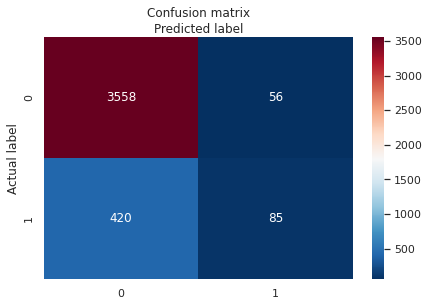

In [ ]:
helper.confusion(y_pred)

#### Cross validation

##### Stratified K-fold

In [ ]:
helper.s_kfold(logistic_regressor)


Cross-Validation Accuracy Scores [0.8903426  0.89209603 0.89290531 0.89142163 0.89100229]

The minimum Cross-Validation Accuracy is  0.8903 

The mean Cross-Validation Accuracy is  0.8916 

The maximum Cross-Validation Accuracy is  0.8929 


##### K-fold

In [ ]:
helper.kfold(logistic_regressor)


Cross-Validation Accuracy Scores [0.89641219 0.8869706  0.89047748 0.88939844 0.89464454]

The minimum Cross-Validation Accuracy is  0.8870 

The mean Cross-Validation Accuracy is  0.8916 

The maximum Cross-Validation Accuracy is  0.8964 


#### Evaluation Metrics

##### Receiver operating characteristic (ROC)

auc=0.7893730103502878


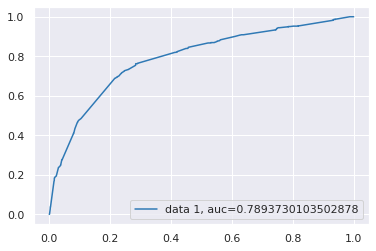

In [ ]:
helper.roc_plot(logistic_regressor)

AUC score for the case is 0.7894. AUC score 1 represents perfect classifier, and 0.5 represents a worthless classifier.

##### F1 Score, Accuracy, Precision, Recall

* F1 score is the amount of data tested for the predictions.

* Accuracy is the subset accuracy. The set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.

* Precision score means the the level up-to which the prediction made by the model is precise. 

* Recall is the amount up-to which the model can predict the outcome. 

In [ ]:
helper.calc_metrics(y_pred)


F1 Score: 0.2632 

Accuracy: 0.8844 

Precision: 0.6028 

Recall: 0.1683 


### XGBoost

Boosting is a sequential technique which works on the principle of an ensemble. It combines a set of weak learners and delivers improved prediction accuracy. At any instant t, the model outcomes are weighed based on the outcomes of previous instant t-1. The outcomes predicted correctly are given a lower weight and the ones miss-classified are weighted higher. 

In [ ]:
# instantiate the model (using the default parameters)
xgboost_classifier = XGBClassifier()

# fit the model with data
xgboost_classifier = xgboost_classifier.fit(X_train,y_train)

# predict
y_pred = xgboost_classifier.predict(X_test)

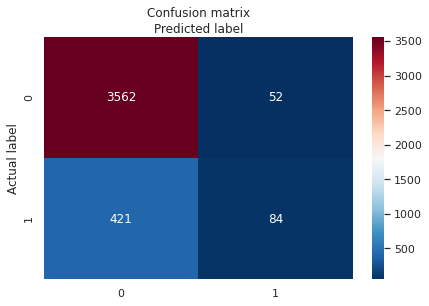

In [ ]:
helper.confusion(y_pred)

#### XGBoost Tree

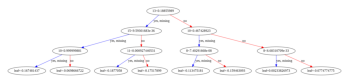

In [ ]:
xgb.plot_tree(xgboost_classifier,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()

#### Cross validation

##### Stratified K-fold

In [ ]:
helper.s_kfold(xgboost_classifier)


Cross-Validation Accuracy Scores [0.89061236 0.89196115 0.89223091 0.89128675 0.89181168]

The minimum Cross-Validation Accuracy is  0.8906 

The mean Cross-Validation Accuracy is  0.8916 

The maximum Cross-Validation Accuracy is  0.8922 


##### K-fold

In [ ]:
helper.kfold(xgboost_classifier)


Cross-Validation Accuracy Scores [0.89573779 0.8869706  0.89209603 0.8896682  0.89423985]

The minimum Cross-Validation Accuracy is  0.8870 

The mean Cross-Validation Accuracy is  0.8917 

The maximum Cross-Validation Accuracy is  0.8957 


#### Evaluation Metrics

##### Receiver operating characteristic (ROC)

auc=0.7926983622545986


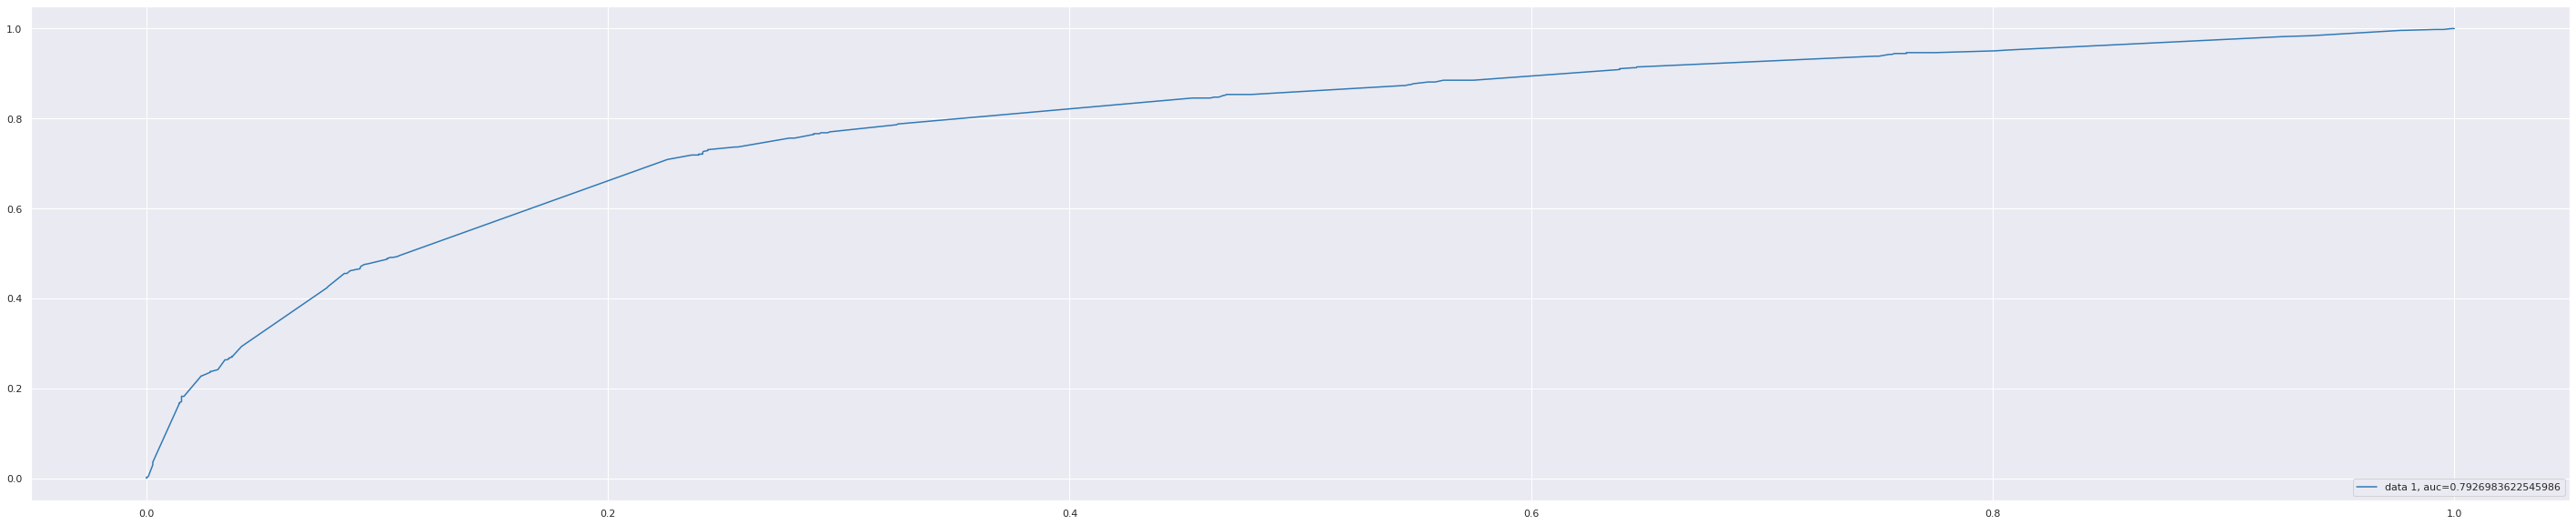

In [ ]:
helper.roc_plot(xgboost_classifier)

AUC score for the case is 0.7927. AUC score 1 represents perfect classifier, and 0.5 represents a worthless classifier.

##### F1 Score, Accuracy, Precision, Recall

* F1 score is the amount of data tested for the predictions.

* Accuracy is the subset accuracy. The set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.

* Precision score means the the level up-to which the prediction made by the model is precise. 

* Recall is the amount up-to which the model can predict the outcome. 

In [ ]:
helper.calc_metrics(y_pred)


F1 Score: 0.2621 

Accuracy: 0.8852 

Precision: 0.6176 

Recall: 0.1663 


### Multilayer Perceptron

A multilayer perceptron or MLP represents a vast artificial neural network, meaning simply that it features more than one perceptron. This gathering of perceptrons is established from an input layer meant to receive the signal, an output layer responsible for a decision or prediction in regards to the input, and an arbitrary number of hidden layers that represent the true computational power of the MLP.

In [ ]:
# create mutli-layer perceptron classifier
perceptron_classifier = MLPClassifier()

# train
perceptron_classifier = perceptron_classifier.fit(X, y)

# make predictions
y_pred = perceptron_classifier.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


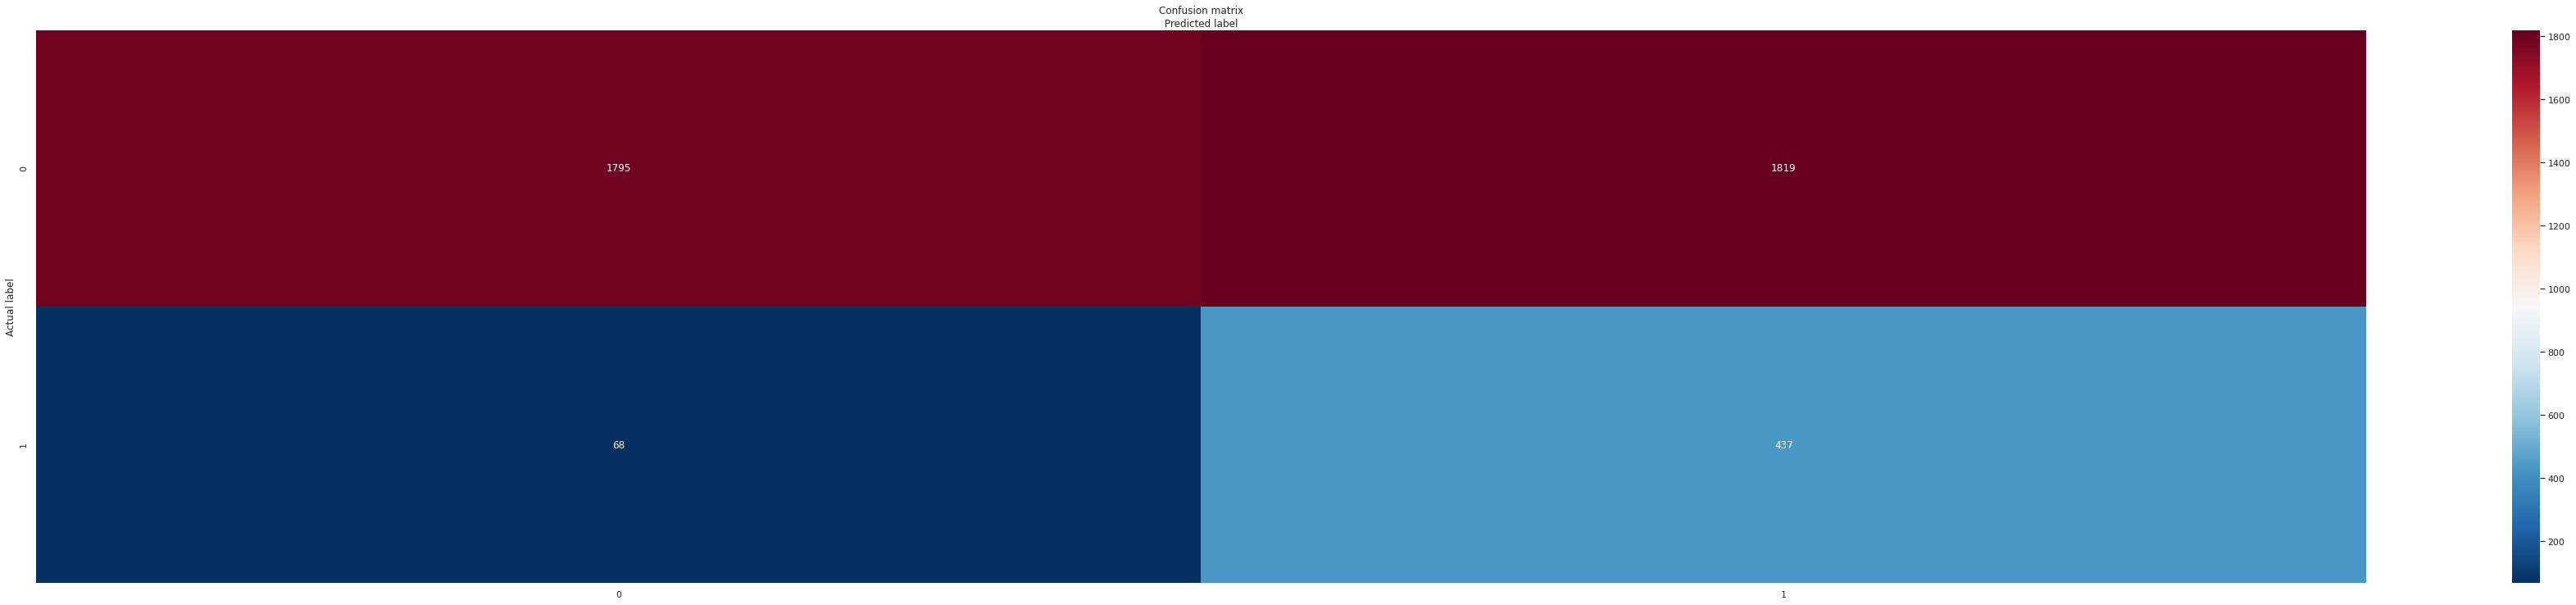

In [ ]:
helper.confusion(y_pred)

#### Cross validation

##### Stratified K-fold

In [ ]:
helper.s_kfold(perceptron_classifier)


Cross-Validation Accuracy Scores [0.89101699 0.89209603 0.89290531 0.89101699 0.89181168]

The minimum Cross-Validation Accuracy is  0.8910 

The mean Cross-Validation Accuracy is  0.8918 

The maximum Cross-Validation Accuracy is  0.8929 


##### K-fold

In [ ]:
helper.kfold(perceptron_classifier)


Cross-Validation Accuracy Scores [0.89600755 0.88683572 0.89182627 0.88885892 0.89450965]

The minimum Cross-Validation Accuracy is  0.8868 

The mean Cross-Validation Accuracy is  0.8916 

The maximum Cross-Validation Accuracy is  0.8960 


#### Evaluation Metrics

##### Receiver operating characteristic (ROC)

auc=0.7102305664988191


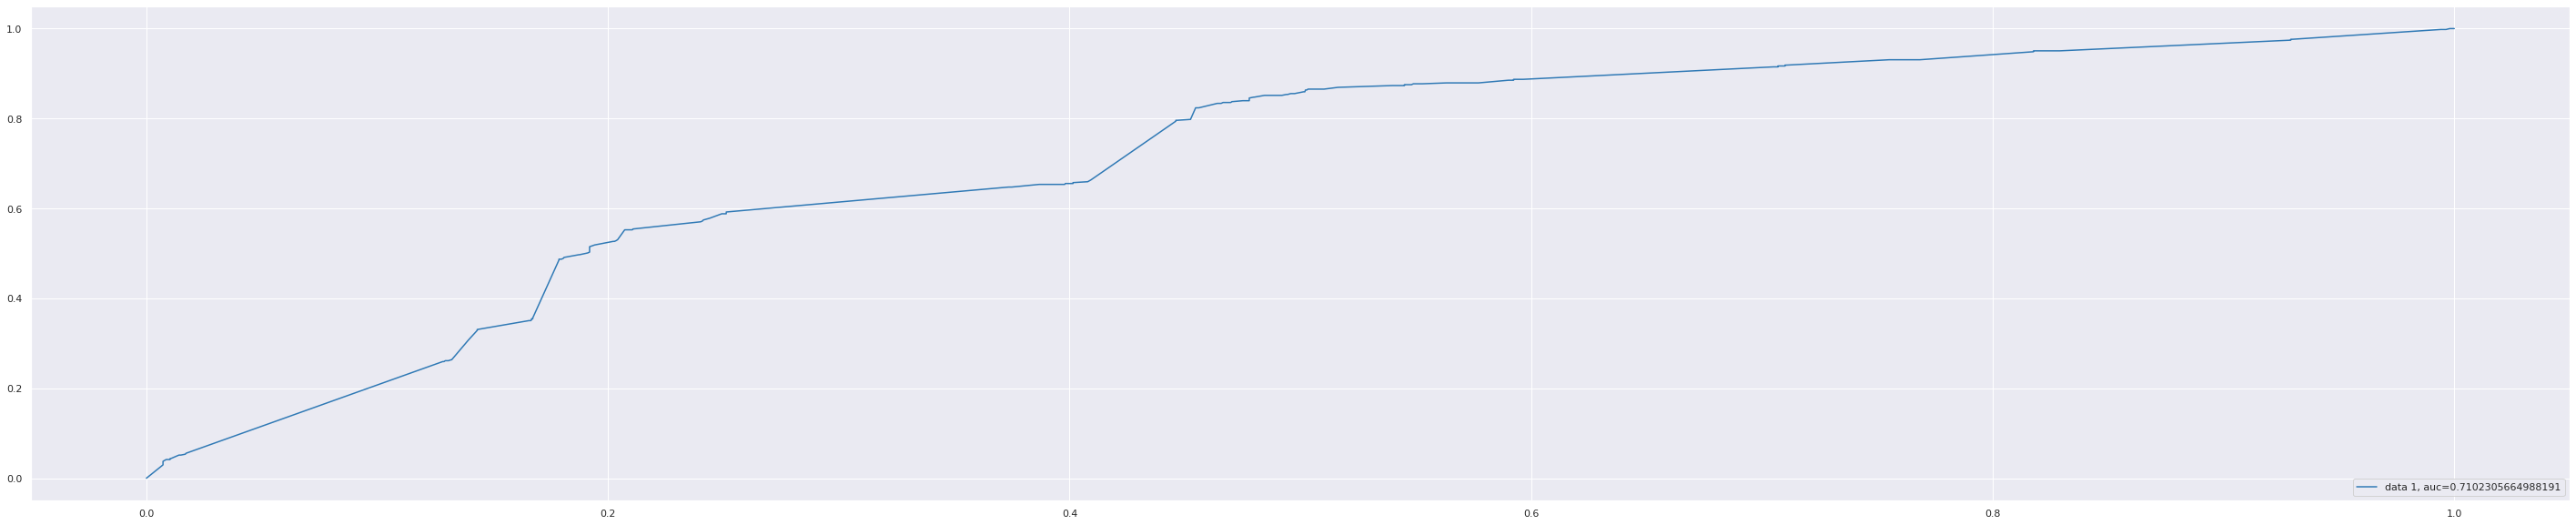

In [ ]:
helper.roc_plot(perceptron_classifier)

AUC score for the case is 0.7102. AUC score 1 represents perfect classifier, and 0.5 represents a worthless classifier.

##### F1 Score, Accuracy, Precision, Recall

* F1 score is the amount of data tested for the predictions.

* Accuracy is the subset accuracy. The set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.

* Precision score means the the level up-to which the prediction made by the model is precise. 

* Recall is the amount up-to which the model can predict the outcome. 

In [ ]:
helper.calc_metrics(y_pred)


F1 Score: 0.3166 

Accuracy: 0.5419 

Precision: 0.1937 

Recall: 0.8653 


### Support Vector Machine

SVM offers very high accuracy compared to other classifiers such as logistic regression, and decision trees. It is known for its kernel trick to handle nonlinear input spaces. It is used in a variety of applications such as face detection, intrusion detection, classification of emails, news articles and web pages, classification of genes, and handwriting recognition.

In [ ]:
#Create a svm Classifier
support_vector_classifier = svm.SVC(kernel='linear', probability=True)

#Train the model using the training sets
support_vector_classifier = support_vector_classifier.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = support_vector_classifier.predict(X_test)

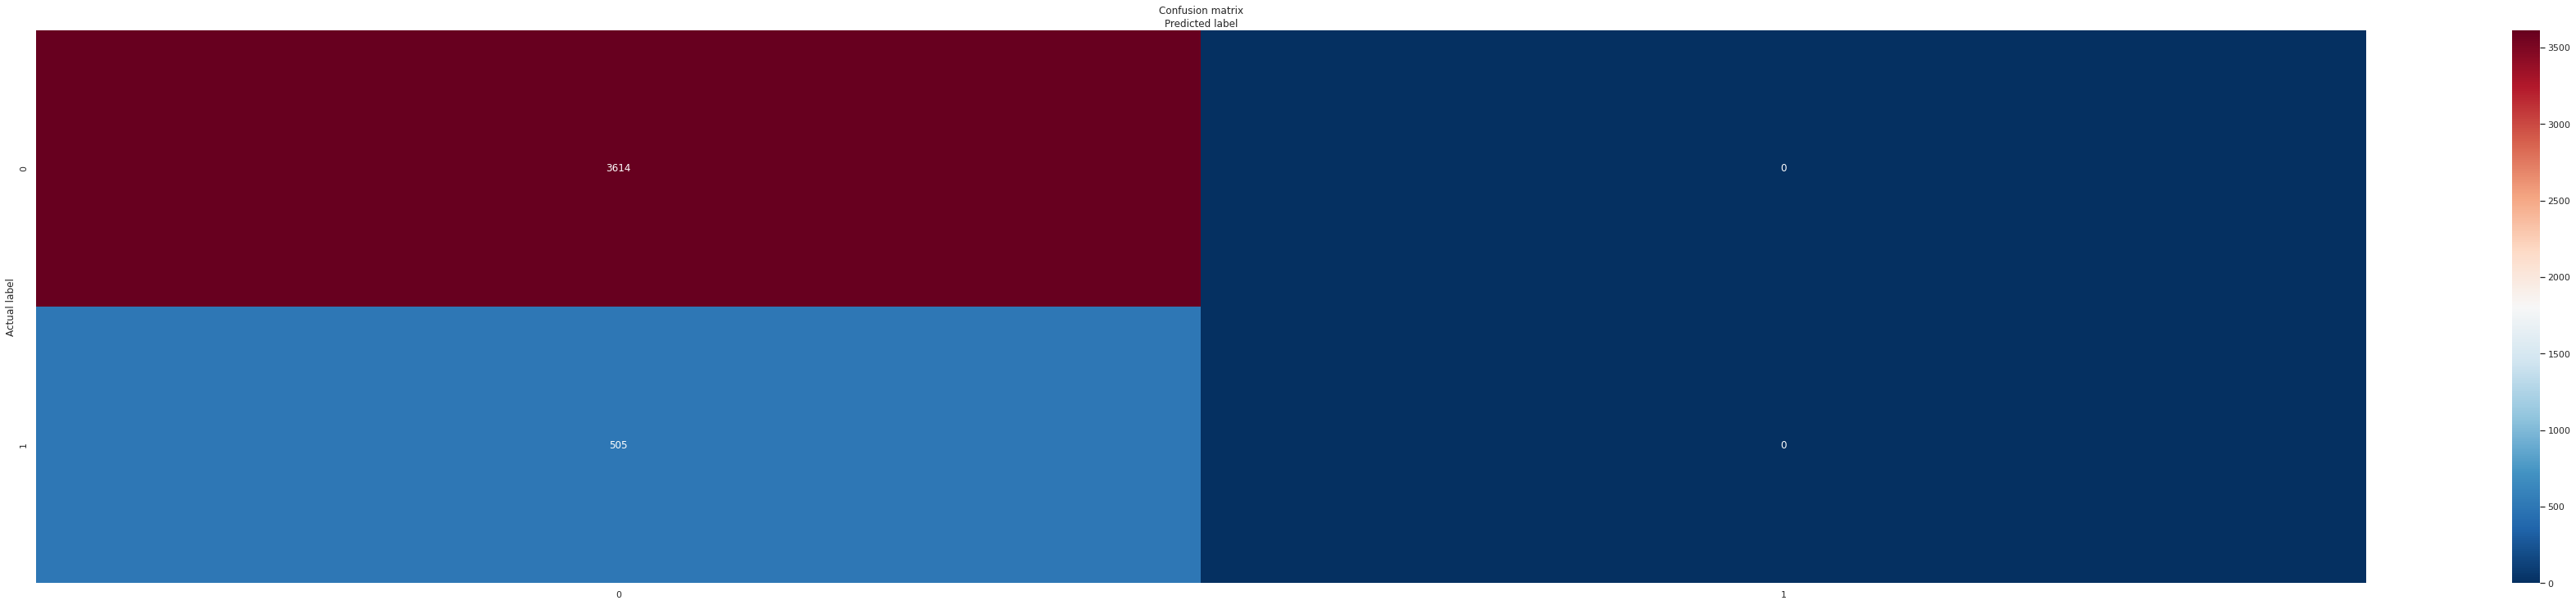

In [ ]:
helper.confusion(y_pred)

#### Cross validation

##### Stratified K-fold

In [ ]:
helper.s_kfold(support_vector_classifier)


Cross-Validation Accuracy Scores [0.88845428 0.88845428 0.88845428 0.88845428 0.88843923]

The minimum Cross-Validation Accuracy is  0.8884 

The mean Cross-Validation Accuracy is  0.8885 

The maximum Cross-Validation Accuracy is  0.8885 


##### K-fold

In [ ]:
helper.kfold(support_vector_classifier)


Cross-Validation Accuracy Scores [0.89371459 0.88454276 0.88804964 0.88319396 0.89275597]

The minimum Cross-Validation Accuracy is  0.8832 

The mean Cross-Validation Accuracy is  0.8885 

The maximum Cross-Validation Accuracy is  0.8937 


#### Evaluation Metrics

##### Receiver operating characteristic (ROC)

auc=0.7461626129408735


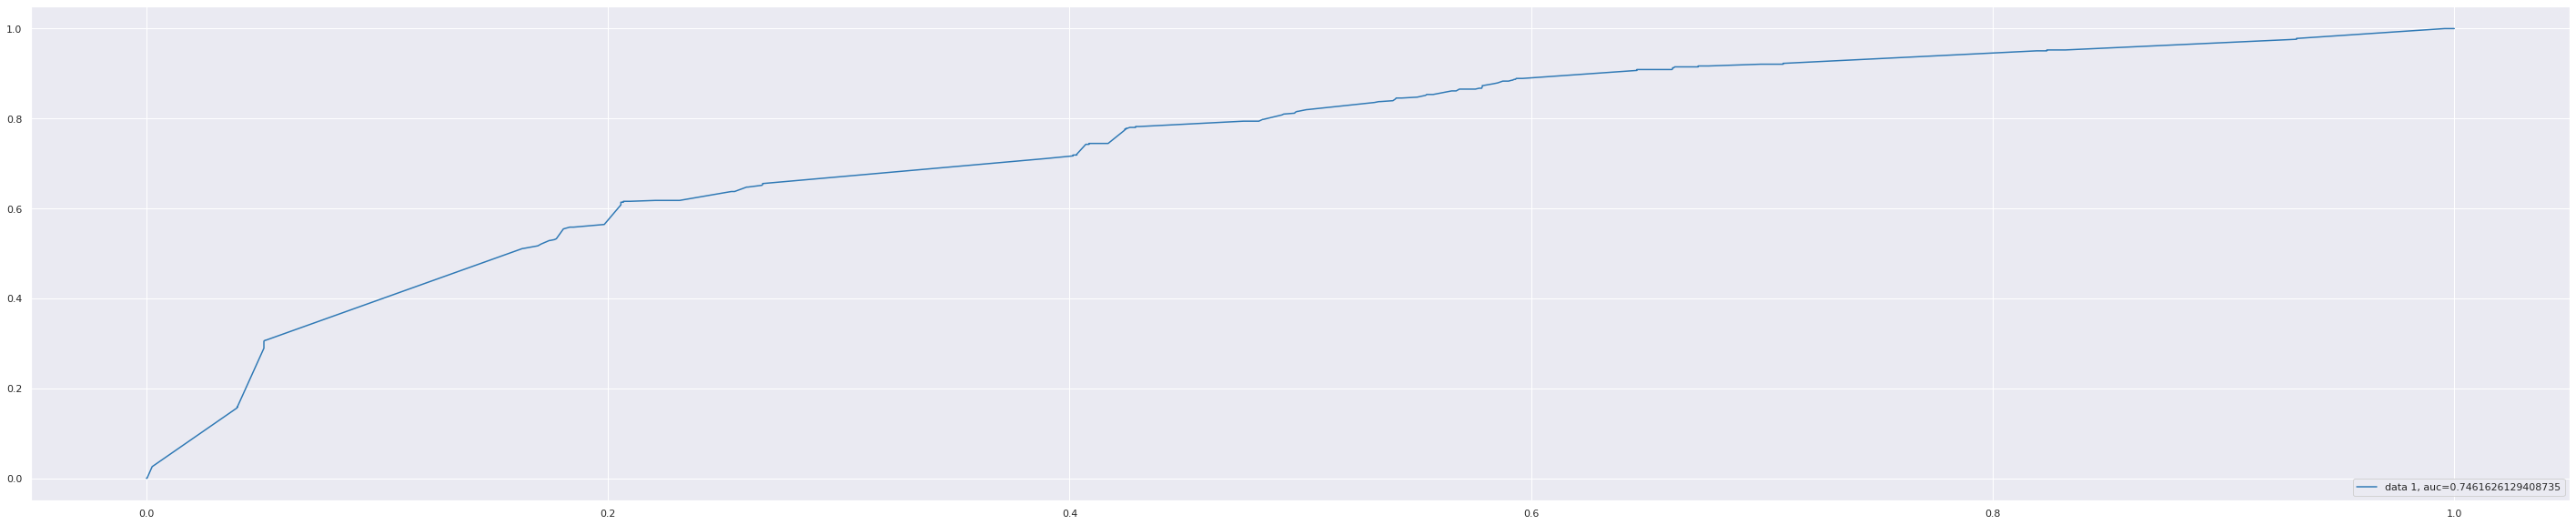

In [ ]:
helper.roc_plot(support_vector_classifier)

AUC score for the case is 0.7462. AUC score 1 represents perfect classifier, and 0.5 represents a worthless classifier.

##### F1 Score, Accuracy, Precision, Recall

* F1 score is the amount of data tested for the predictions.

* Accuracy is the subset accuracy. The set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.

* Precision score means the the level up-to which the prediction made by the model is precise. 

* Recall is the amount up-to which the model can predict the outcome. 

In [ ]:
helper.calc_metrics(y_pred)


F1 Score: 0.0000 

Accuracy: 0.8774 

Precision: 0.0000 

Recall: 0.0000 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Decision Trees

A decision tree is a flowchart-like tree structure where an internal node represents feature(or attribute), the branch represents a decision rule, and each leaf node represents the outcome. The topmost node in a decision tree is known as the root node. 

It learns to partition on the basis of the attribute value. It partitions the tree in recursively manner call recursive partitioning. This flowchart-like structure helps you in decision making. 

It's visualization like a flowchart diagram which easily mimics the human level thinking. That is why decision trees are easy to understand and interpret.

In [ ]:
# Create Decision Tree classifer object
decision_tree_classifer = DecisionTreeClassifier(max_depth=5)

# Train Decision Tree Classifer
decision_tree_classifer = decision_tree_classifer.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = decision_tree_classifer.predict(X_test)

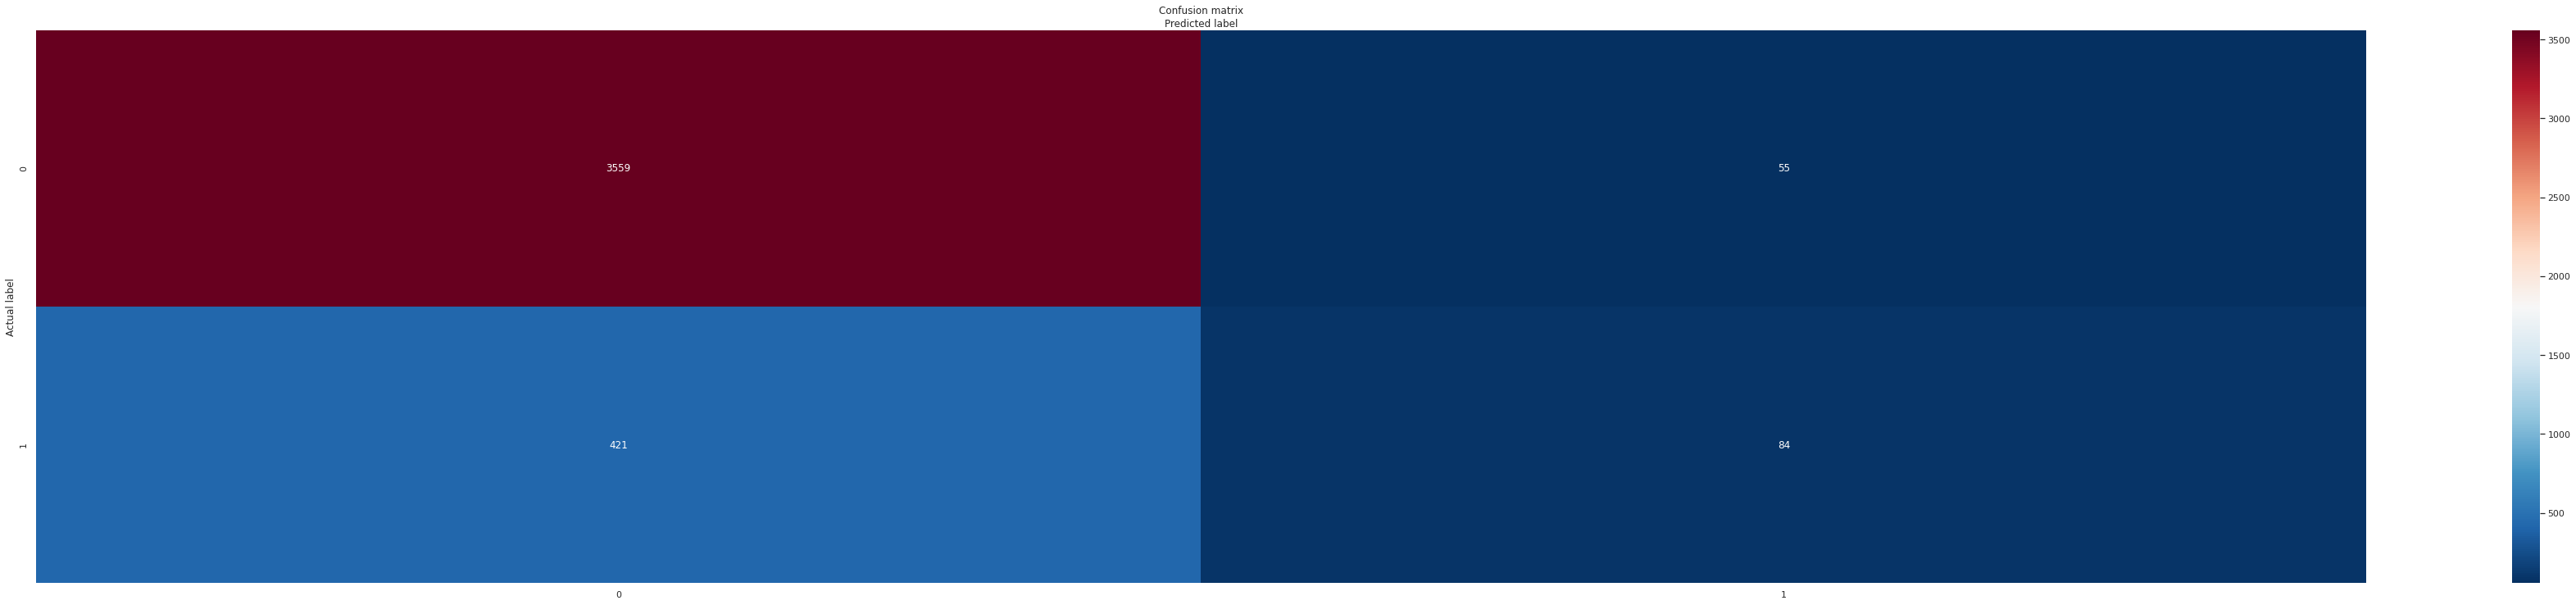

In [ ]:
helper.confusion(y_pred)

#### Decision Tree


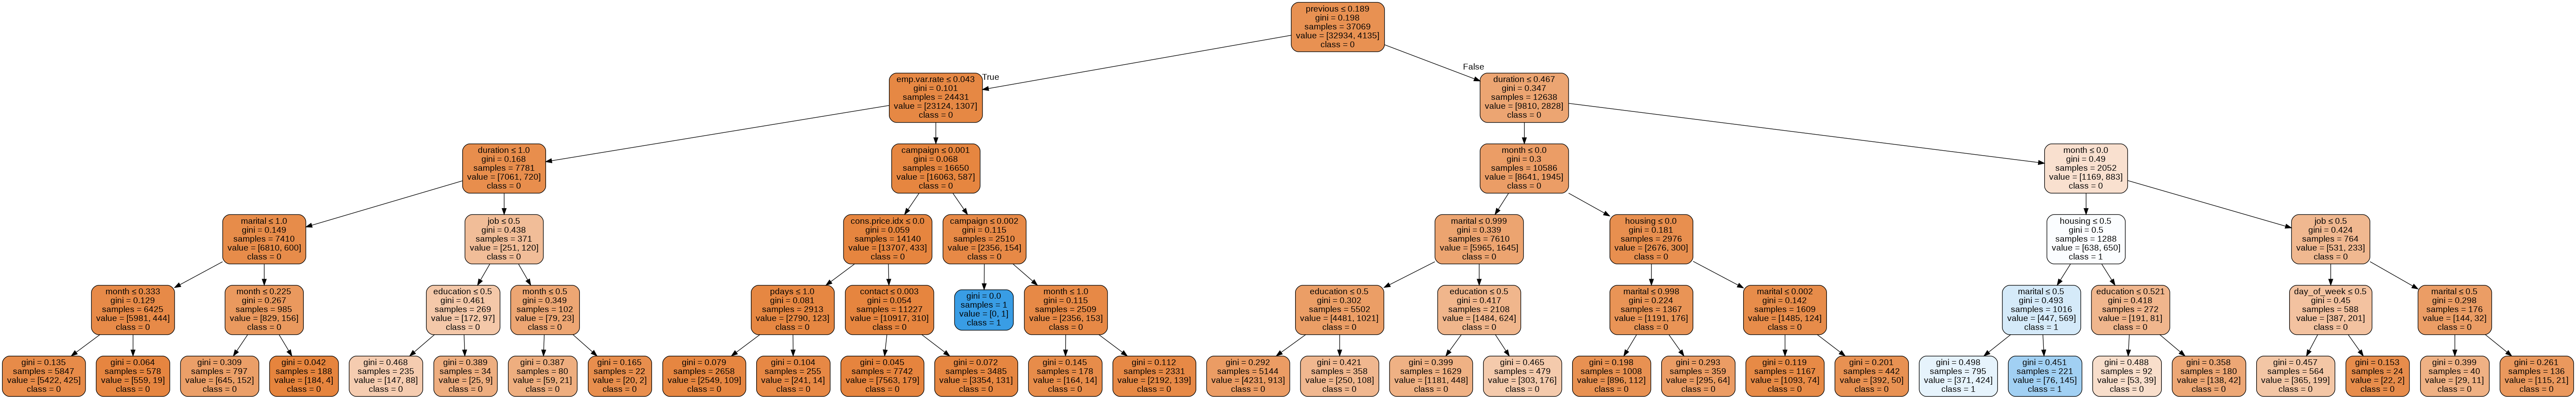

In [ ]:
dot_data = StringIO()
export_graphviz(decision_tree_classifer, out_file=dot_data, filled=True, rounded=True, special_characters=True,feature_names = X.columns,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('Term Deposits.png')
Image(graph.create_png())

#### Cross validation

##### Stratified K-fold

In [ ]:
helper.s_kfold(decision_tree_classifer)


Cross-Validation Accuracy Scores [0.89088211 0.89223091 0.89209603 0.89142163 0.89167678]

The minimum Cross-Validation Accuracy is  0.8909 

The mean Cross-Validation Accuracy is  0.8917 

The maximum Cross-Validation Accuracy is  0.8922 


##### K-fold

In [ ]:
helper.kfold(decision_tree_classifer)


Cross-Validation Accuracy Scores [0.89560291 0.88724036 0.89115187 0.88818452 0.89423985]

The minimum Cross-Validation Accuracy is  0.8872 

The mean Cross-Validation Accuracy is  0.8913 

The maximum Cross-Validation Accuracy is  0.8956 


#### Evaluation Metrics

##### Receiver operating characteristic (ROC)

auc=0.7890598716761549


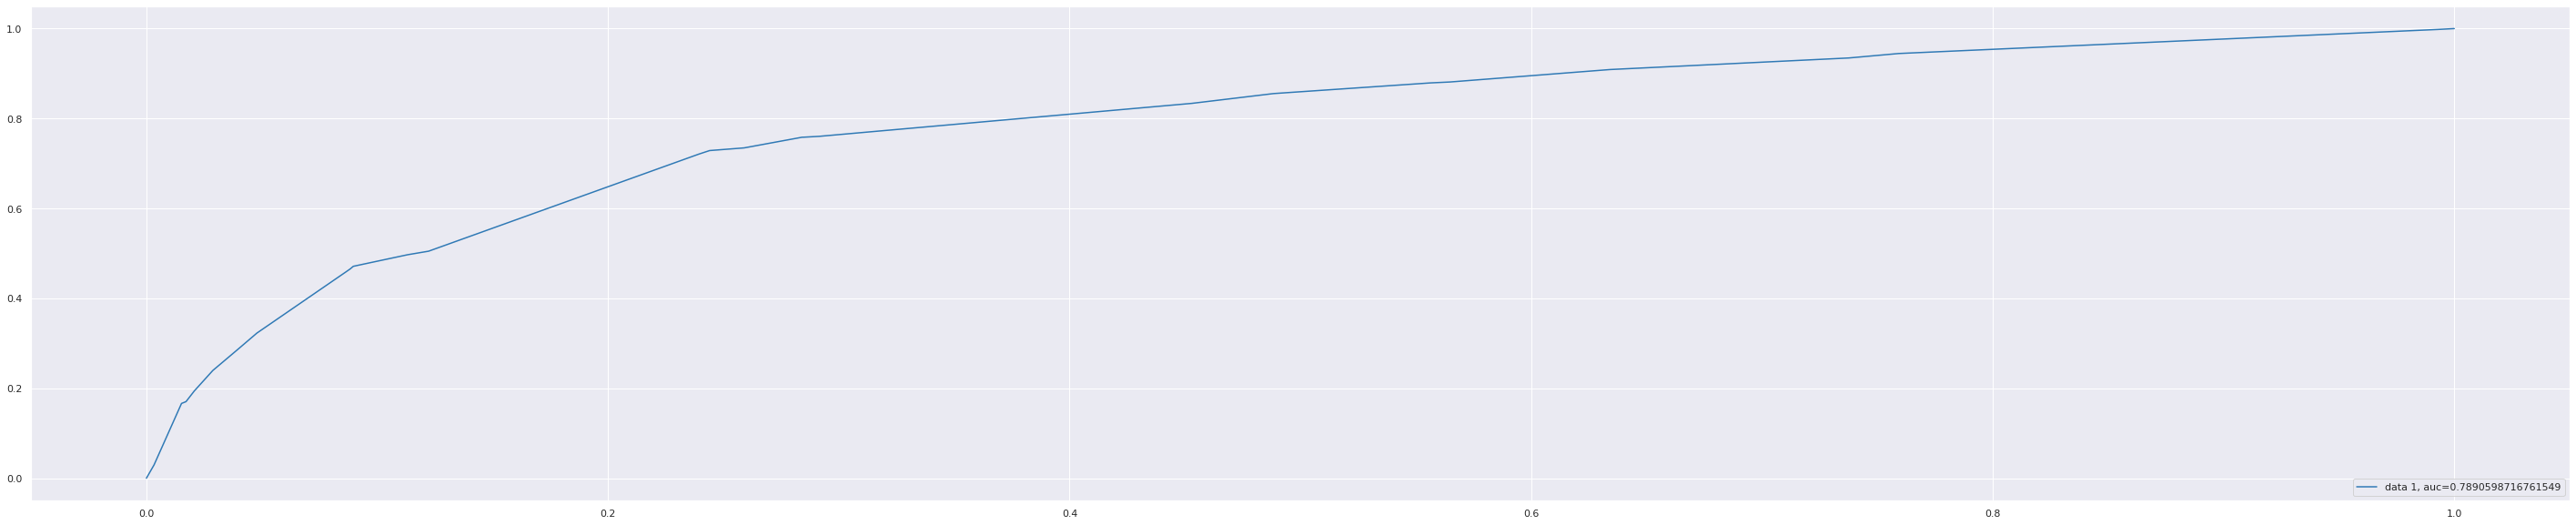

In [ ]:
helper.roc_plot(decision_tree_classifer)

AUC score for the case is 0.7891. AUC score 1 represents perfect classifier, and 0.5 represents a worthless classifier.

##### F1 Score, Accuracy, Precision, Recall

* F1 score is the amount of data tested for the predictions.

* Accuracy is the subset accuracy. The set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.

* Precision score means the the level up-to which the prediction made by the model is precise. 

* Recall is the amount up-to which the model can predict the outcome. 

In [ ]:
helper.calc_metrics(y_pred)


F1 Score: 0.2609 

Accuracy: 0.8844 

Precision: 0.6043 

Recall: 0.1663 


### Random Forests

Random forests is a supervised learning algorithm. It can be used both for classification and regression. It is also the most flexible and easy to use algorithm. 

A forest is comprised of trees. It is said that the more trees it has, the more robust a forest is. Random forests creates decision trees on randomly selected data samples, gets prediction from each tree and selects the best solution by means of voting. It also provides a pretty good indicator of the feature importance.

In [ ]:
# create classifier object 
random_forest_classifier = RandomForestClassifier() 
  
# fit the classifier with x and y data 
random_forest_classifier = random_forest_classifier.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = random_forest_classifier.predict(X_test)

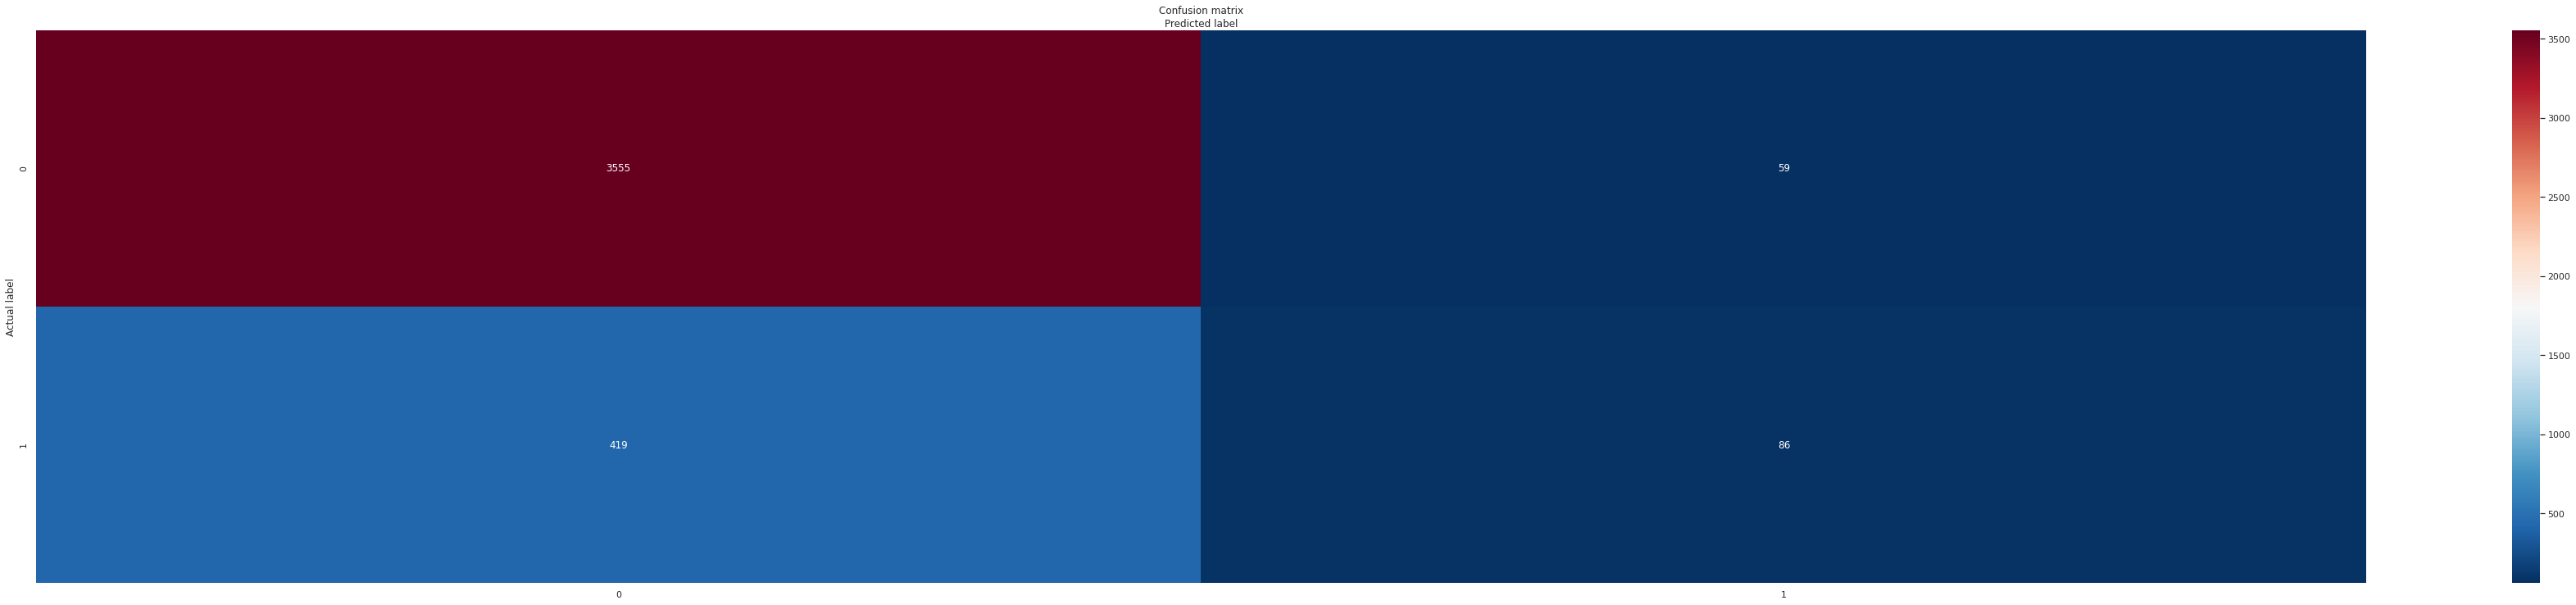

In [ ]:
helper.confusion(y_pred)

#### Cross validation

##### Stratified K-fold

In [ ]:
helper.s_kfold(random_forest_classifier)


Cross-Validation Accuracy Scores [0.89020772 0.89142163 0.89182627 0.88926356 0.8901929 ]

The minimum Cross-Validation Accuracy is  0.8893 

The mean Cross-Validation Accuracy is  0.8906 

The maximum Cross-Validation Accuracy is  0.8918 


##### K-fold

In [ ]:
helper.kfold(random_forest_classifier)


Cross-Validation Accuracy Scores [0.89506339 0.8856218  0.89047748 0.88724036 0.89329556]

The minimum Cross-Validation Accuracy is  0.8856 

The mean Cross-Validation Accuracy is  0.8903 

The maximum Cross-Validation Accuracy is  0.8951 


#### Evaluation Metrics

##### Receiver operating characteristic (ROC)

auc=0.7882648336776125


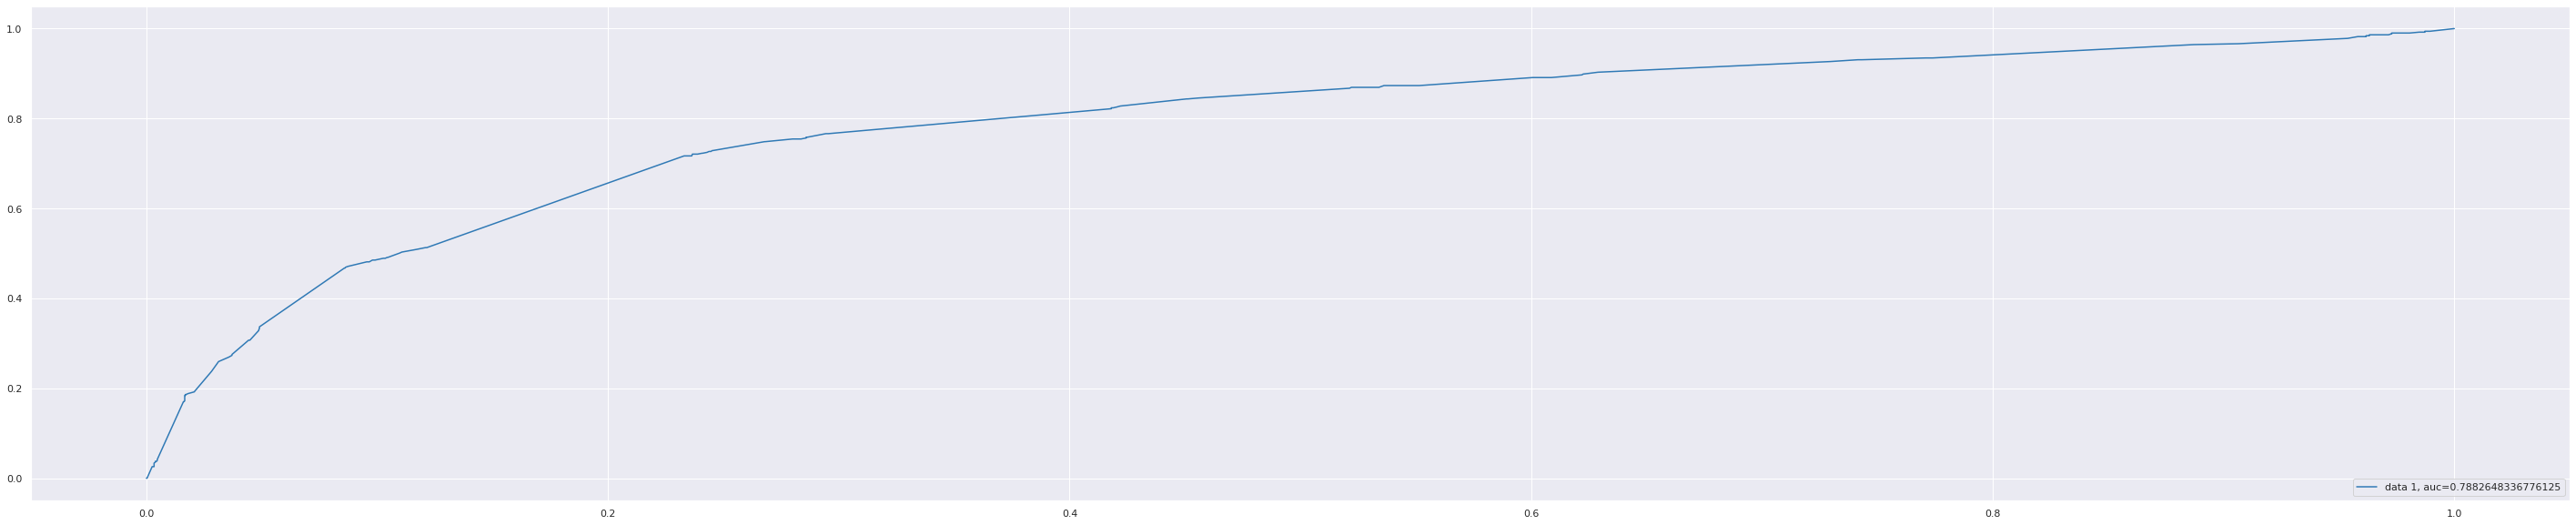

In [ ]:
helper.roc_plot(random_forest_classifier)

AUC score for the case is 0.7883. AUC score 1 represents perfect classifier, and 0.5 represents a worthless classifier.

##### F1 Score, Accuracy, Precision, Recall

* F1 score is the amount of data tested for the predictions.

* Accuracy is the subset accuracy. The set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.

* Precision score means the the level up-to which the prediction made by the model is precise. 

* Recall is the amount up-to which the model can predict the outcome. 

In [ ]:
helper.calc_metrics(y_pred)


F1 Score: 0.2646 

Accuracy: 0.8840 

Precision: 0.5931 

Recall: 0.1703 


# References
Navlani, A., 2018. Decision Tree Classification In Python. [online] DataCamp Community. Available at: <https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python>.

Navlani, A., 2019. Support Vector Machines With Scikit-Learn. [online] DataCamp Community. Available at: <https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python?utm_source=adwords_ppc&utm_campaignid=1455363063&utm_adgroupid=65083631748&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=&utm_creative=278443377086&utm_targetid=aud-299261629574:dsa-429603003980&utm_loc_interest_ms=&utm_loc_physical_ms=9076857&gclid=CjwKCAjwyo36BRAXEiwA24CwGa2OoIYBqmBWZL_KcePBXotc_Ky7MN5xnyT0eF-U0DcAQfgaQ9RS1RoCx0IQAvD_BwE>.

Navlani, A., 2020. Understanding Logistic Regression In Python. [online] DataCamp Community. Available at: <https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python?utm_source=adwords_ppc&utm_campaignid=1455363063&utm_adgroupid=65083631748&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=&utm_creative=332602034364&utm_targetid=aud-299261629574:dsa-429603003980&utm_loc_interest_ms=&utm_loc_physical_ms=9076857&gclid=CjwKCAjwyo36BRAXEiwA24CwGW_AlFxbL4od4tD3zMDp3OzlVqetNSFDL_4xhwfQnyxxVXo9WJ2vlxoC6cwQAvD_BwE>.

Pathak, M., 2020. Using Xgboost In Python. [online] DataCamp Community. Available at: <https://www.datacamp.com/community/tutorials/xgboost-in-python?utm_source=adwords_ppc&utm_campaignid=1455363063&utm_adgroupid=65083631748&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=&utm_creative=332602034364&utm_targetid=aud-299261629574:dsa-429603003980&utm_loc_interest_ms=&utm_loc_physical_ms=9076857&gclid=CjwKCAjwyo36BRAXEiwA24CwGU0BzB6TeKG_Ns2Kv7MskUTbIAHkS3ZgfZan1mfSXTqwA9os59WGnxoCiuUQAvD_BwE>.

Pythonprogramminglanguage.com. 2020. Multilayer Perceptron - Learn Python. [online] Available at: <https://pythonprogramminglanguage.com/multilayer-perceptron/>.

Quantdare. 2020. Outliers Detection With Autoencoder, A Neural Network ⋆ Quantdare. [online] Available at: <https://quantdare.com/outliers-detection-with-autoencoder-neural-network/>.

Scikit-learn.org. 2020. Sklearn.Decomposition.PCA — Scikit-Learn 0.23.2 Documentation. [online] Available at: <https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html>.

Scikit-learn.org. 2020. Sklearn.Preprocessing.Standardscaler — Scikit-Learn 0.23.2 Documentation. [online] Available at: <https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html>.